# Project: Getting to Philosophy


"Getting to Philosophy" is defined on wikipedia as:
"Clicking on the first link in the main text of an English Wikipedia article, and then repeating the process for subsequent articles, usually leads to the Philosophy article. In February 2016, this was true for 97% of all articles in Wikipedia, an increase from 94.52% in 2011. The remaining articles lead to an article without any outgoing wikilinks, to pages that do not exist, or get stuck in loops."

https://en.wikipedia.org/wiki/Wikipedia:Getting_to_Philosophy

The program should receive a Wikipedia link as an input, go to another normal link and repeat this process until either Philosophy page is reached, or we are in an article without any outgoing Wikilinks, or stuck in a loop.
This process is repeated to create the whole network of a sample size of your choice

A "normal link" is a link from the main page article, not in a box, is blue (red is for non-existing articles), not in parentheses, not italic and not a footnote. You don't have to check style tables or other fancy things, it is enough that the script works with the current Wikipedia style (for example you can use 'class' attribute in Wikipedia tags). For easy validation, please print all visited links to the standard output.

you can use a 0.5 second timeout between queries to avoid heavy load on Wikipedia (sleep function from time module).

You can use https://en.wikipedia.org/wiki/Special:Random to check this hypothesis at home.


In [45]:
from bs4 import BeautifulSoup
import urllib
import time
import sys
import requests
import re
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

### Getting to Philosophy will stop when : 
1. reaches the Philosophy article
2. reaches 100 article without reaching the Philosophy article 
3. get into an article with no links 
4. stuck in a loop

In [46]:
#timeout
time_out=0
#size of the network
N=1000

In [47]:
# start
start_url = "https://en.wikipedia.org/wiki/Special:Random" 
#start_url = "https://en.wikipedia.org/wiki/State" 
# target
target_url = "https://en.wikipedia.org/wiki/Philosophy"
# store the visited article 
visited_urls = [start_url]

In [48]:
# Remove text within NESTED parenthese
def remove_text_inside_brackets(text, brackets="()"):
    count = [0] * (len(brackets) // 2) # count open/close brackets
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: # found bracket
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close # `+1`: open, `-1`: close
                if count[kind] < 0: # unbalanced bracket
                    count[kind] = 0  # keep it
                else:  # found bracket to remove
                    break
        else: # character is not a [balanced] bracket
            if not any(count): # outside brackets
                saved_chars.append(character)
    return ''.join(saved_chars)

In [49]:
# Remove text within NESTED parenthese
def remove_text_inside_sq_brackets(text, brackets="[]"):
    count = [0] * (len(brackets) // 2) # count open/close brackets
    saved_chars = []
    for character in text:
        for i, b in enumerate(brackets):
            if character == b: # found bracket
                kind, is_close = divmod(i, 2)
                count[kind] += (-1)**is_close # `+1`: open, `-1`: close
                if count[kind] < 0: # unbalanced bracket
                    count[kind] = 0  # keep it
                else:  # found bracket to remove
                    break
        else: # character is not a [balanced] bracket
            if not any(count): # outside brackets
                saved_chars.append(character)
    return ''.join(saved_chars)

In [50]:
def find_first_link(url):
    response = requests.get(url)
    html = response.text
    # Remove sup, small and parenthesized text
    html = remove_text_inside_brackets(html)
    html = remove_text_inside_sq_brackets(html)
    html = re.sub(r'<sup.*?</sup>', "", html)
    html = re.sub(r'<small.*?</small>', "", html)
    soup = BeautifulSoup(html, "html.parser")

    # This div stars with the body of the article
    content_div = soup.find(id="mw-content-text").find(class_="mw-parser-output")

    # Delete red links
    for s in content_div.find_all(class_="new"):
        s.replace_with("")

    # if the link contains no links it remains None
    article_link = None

    # Find all the direct children of content_div that are paragraphs
    not_selfrefering = 0
    for element in content_div.find_all("p", recursive=False):
        # Find links to direct children
        if element.find("a", recursive=False):
            # some pages contain links that refer to paragraphs within the same page, they begin with #
            # we will skip them using the following loop
            # also, pages of towns usually contain a map inside the first <p> tag 
            # its class is "mw-kartographer-map mw-kartographer-container floatright", so we disregard it
            for link in element.find_all("a", class_= not "mw-kartographer-map mw-kartographer-container floatright", recursive = False):
                article_link = link.get('href')
                if "#" not in link.get('href'):
                    article_link = link.get('href')
                    not_selfrefering = 1
                    break
        # Article links end with an underscore sometime, but not always. This would create duplicate nodes for the same article
        if not_selfrefering == 1:
            if article_link.endswith("_"):
                article_link = article_link.removesuffix('_')
            break
    
    # Certain wikipedia pages are lists that start with "may refer to"
    # in this case we will need to keep the text in between parenthesis
    if not article_link and ("may refer to" in str(content_div.find_all("p", recursive=False)) or "most commonly refers to" in str(content_div.find_all("p", recursive=False))):
        response = requests.get(url)
        html = response.text
        soup = BeautifulSoup(html, "html.parser")
        html = remove_text_inside_sq_brackets(html)

        # Recreate content_div but with parenthesis

        content_div = soup.find(id="mw-content-text").find(class_="mw-parser-output")
        for s in content_div.find_all(class_="new"):
            s.replace_with("")
       
       # class = "toclevel-1 tocsection-1" are links that 
        for element in content_div.find_all("li", class_=not"toclevel-1 tocsection-1"):
            #find only the direct children
            if element.find("a"):
                article_link = element.find("a").get('href')
                break

    if not article_link:
        return

    # Build a full url 
    first_link = urllib.parse.urljoin(
        'https://en.wikipedia.org/', article_link)

    return first_link

In [51]:
def continue_scraping(scraping_history, target_url, max_steps=100):
    # When reaches to philosphy
    if scraping_history[-1] == target_url:
        print("https://en.wikipedia.org/wiki/Philosophy")
        return False
    # max iterations 
    elif len(scraping_history) > max_steps:
        print("Maximum (100) searches reached, interrupted.")
        return False
    elif scraping_history[-1] in scraping_history[:-1]:
        print("We are in a Loop , interrupted.")
        return False
    else:
        return True

In [52]:
def nodes_from_path(path):
        for i in range (0, len(path)):
            path[i]=path[i].replace("https://en.wikipedia.org/wiki/","",1)   #remove link to create name of node
        return path

def node_from_link(link):
    link = link.replace("https://en.wikipedia.org/wiki/","",1)
    return link


In [53]:
visited_urls=[start_url]
first_link = find_first_link(visited_urls[-1])
visited_urls.append(first_link)
print(node_from_link(visited_urls[-1]))

Dominican_Republic


In [54]:
def generate_path():
    #generate path
    visited_urls=[start_url]
    while continue_scraping(visited_urls, target_url):
        #print first link
        print(visited_urls[-1])
        first_link = find_first_link(visited_urls[-1])
        # when arrive at an article with no links
        if not first_link:
            print("Arrived at an article with no links, search aborted.")
            break
        visited_urls.append(first_link)
        if time_out==1:
            time.sleep(0.4)  # Slow things down so as to not overload Wikipedia's servers
        path=visited_urls

    nodes_from_path(path)
    
    return path

In [55]:
def generate_network(DG):
    #generate path
    visited_urls=[start_url]
    while continue_scraping(visited_urls, target_url):
        #print first link
        print(visited_urls[-1])
        first_link = find_first_link(visited_urls[-1])
        # when arrive at an article with no links
        if not first_link:
            print("Arrived at an article with no links, search aborted.")
            break

        if time_out==1:
            time.sleep(0.4)  # Slow things down so as to not overload Wikipedia's servers
        
        if node_from_link(visited_urls[-1]) != "Special:Random":
            DG.add_edge(node_from_link(visited_urls[-1]),node_from_link(first_link))

        visited_urls.append(first_link)
        

    return DG

In [56]:
network=nx.DiGraph()
for n in range(0,N):
    print ("Path #",n+1)
    network = generate_network(network)

Path # 1
https://en.wikipedia.org/wiki/Special:Random
https://en.wikipedia.org/wiki/Switzerland
https://en.wikipedia.org/wiki/Landlocked_country
https://en.wikipedia.org/wiki/Country
https://en.wikipedia.org/wiki/Polity
https://en.wikipedia.org/wiki/Collective_identity
https://en.wikipedia.org/wiki/Belongingness
https://en.wikipedia.org/wiki/Emotion
https://en.wikipedia.org/wiki/Mental_state
https://en.wikipedia.org/wiki/Mind
https://en.wikipedia.org/wiki/Phenomenon
https://en.wikipedia.org/wiki/Philosophy
Path # 2
https://en.wikipedia.org/wiki/Special:Random
https://en.wikipedia.org/wiki/Judd_Apatow
https://en.wikipedia.org/wiki/Apatow_Productions
https://en.wikipedia.org/wiki/Film
https://en.wikipedia.org/wiki/Cinematography
We are in a Loop , interrupted.
Path # 3
https://en.wikipedia.org/wiki/Special:Random
https://en.wikipedia.org/wiki/Victoria_Independent_School_District
https://en.wikipedia.org/wiki/School_district
https://en.wikipedia.org/wiki/Primary_school
https://en.wikipedi

AttributeError: 'NoneType' object has no attribute 'find_all'

In [ ]:
print(network)

DiGraph with 936 nodes and 929 edges


In [ ]:
nx.pagerank(network)

{'Rugby_union': 0.0001755345747719649,
 'Team_sport': 0.0016730920442099024,
 'Sport': 0.0021813878091098155,
 'Competition': 0.002306573719235442,
 'Rivalry': 0.002137462486977671,
 'Social_group': 0.0028850072098867263,
 'Social_science': 0.0037820814744496715,
 'Branches_of_science': 0.011091228418525398,
 'Science': 0.031710862065931704,
 'Scientific_method': 0.027141253004077485,
 'Empirical_evidence': 0.023248082411205063,
 'Proposition': 0.019937986200352517,
 'Logic': 0.017106461623855884,
 'Reason': 0.01635910467248046,
 'Consciousness': 0.019525362947196014,
 'Sentience': 0.016747612784303624,
 'Emotion': 0.019776795458394454,
 'Mental_state': 0.016945103244259768,
 'Mind': 0.014555213071561412,
 'Phenomenon': 0.012585659896194699,
 'Philosophy': 0.013699197002864708,
 'Ben_Aldridge': 0.0001755345747719649,
 'Ben_Aldridge_(actor)': 0.00032472434253178666,
 'Thomas_Wayne': 0.0004515477941057345,
 'DC_Comics': 0.0005593861936535945,
 'American_comic_book': 0.0006511299860770237

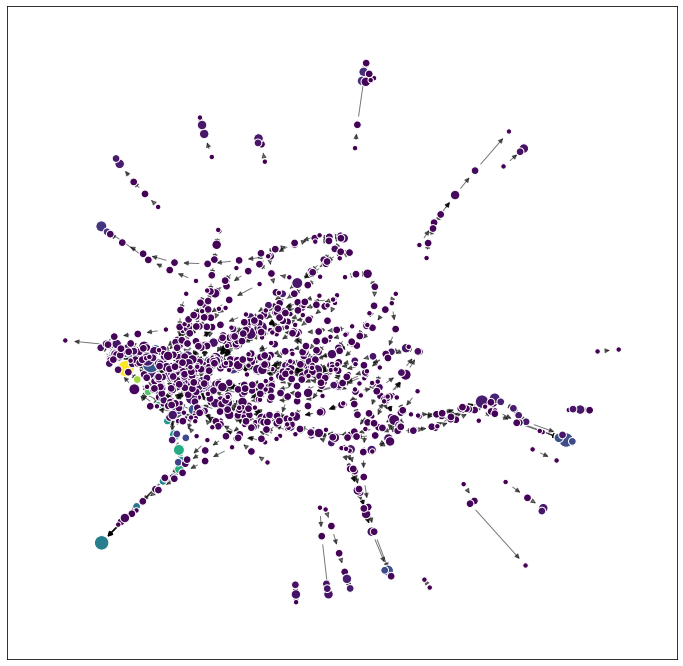

In [ ]:

plt.figure(figsize=(12,12))

# sizes proportional to degree
d = dict(network.degree)
sizes = [v * 30 for v in d.values()]

# colors based on a PageRank
d_pr = nx.pagerank(network)
colors = [d_pr[node] for node in network.nodes]
position = nx.spring_layout(network)

# draw nodes and edges
nx.draw_networkx_nodes(network, pos=position, nodelist=d.keys(), node_size=sizes,node_color=colors, edgecolors='#ffffff')
nx.draw_networkx_edges(network, pos=position, edge_color='#00000088');

path length dist
bottlenecks
probability of reaching an attractor
path lengths of paths that do not lead to phil